## Learning and Control of a Stabilizable Bilinear Model for Van Der Pol system

In [7]:
#Installing and importing required packages
import pkgutil
if not pkgutil.find_loader("dreal"):
  !curl https://raw.githubusercontent.com/dreal/dreal4/master/setup/ubuntu/18.04/install.sh | bash
  !pip install dreal --upgrade
from dreal import *
import torch 
import torch.nn.functional as F
import numpy as np
import timeit 
import matplotlib.pyplot as plt
from IPython import display


In [8]:
def CheckLyapunovKoopman(x, f, V, ball_lb, ball_ub, config, epsilon,K,z):        
    ball= Expression(0)
    lie_derivative_of_V = Expression(0)
    
    for i in range(len(z)):
        ball = x[0]*x[0]+x[1]*x[1]+x[2]*x[2]
        lie_derivative_of_V += f[i]*V.Differentiate(x[0])/z[i].Differentiate(x[0])+ f[i]*V.Differentiate(x[1])/z[i].Differentiate(x[1])
    ball_in_bound = logical_and(ball_lb <= ball, ball <= ball_ub,ball_lb<=x[0],ball_lb<=x[1],x[0]<=ball_ub,x[1]<=ball_ub,x[2]<=ball_ub,\
                                ball_lb<=x[2])

    # Constraint: x ∈ Ball → (V(c, x) > 0 ∧ Lie derivative of V <= 0)     
    condition = logical_and(logical_imply(ball_in_bound, V >= 0),
                           logical_imply(ball_in_bound, lie_derivative_of_V <= epsilon))

    return CheckSatisfiability(logical_not(condition),config)

def AddCounterexamples(x,CE,N): 
    c = []
    nearby= []
    for i in range(CE.size()):
        c.append(CE[i].mid())
        lb = CE[i].lb()
        ub = CE[i].ub()
        nearby_ = np.random.uniform(lb,ub,N)
        nearby.append(nearby_)
    for i in range(N):
        n_pt = []
        for j in range(x.shape[1]):
            n_pt.append(nearby[j][i])             
        x = torch.cat((x, torch.tensor([n_pt])), 0)
    return x
  
def dtanh(s):
    # Derivative of activation
    return 1.0 - s**2

def Tune(x):
    # Circle function values
    y = []
    for r in range(0,len(x)):
        v = 0 
        for j in range(x.shape[1]):
            v += x[r][j]**2
        f = [torch.sqrt(v)]
        y.append(f)
    y = torch.tensor(y)
    return y

## Neural network model for Control Lyapunov function (CLF), Encoder and the Decoder


In [9]:
# Control Lyapunov function (CLF)
class CLF(torch.nn.Module):
    
    def __init__(self,n_input,n_hidden,n_output):
        super(CLF, self).__init__()
        self.layer1 = torch.nn.Linear(n_input, n_hidden)
        self.layer2 = torch.nn.Linear(n_hidden,n_output)


    def forward(self,x):
        sigmoid = torch.nn.Tanh()
        h_1 = sigmoid(self.layer1(x))
        out = sigmoid(self.layer2(h_1)).float()
        return out

# Encoder/ observables
class Encoder(torch.nn.Module):
    
    def __init__(self,n_input,n_hidden,n_output):
        super(Encoder, self).__init__()
        self.layer1 = torch.nn.Linear(n_input, n_hidden)
        self.layer2 = torch.nn.Linear(n_hidden,n_output)
        self.control = torch.nn.Linear(n_input,1,bias=False)

    def forward(self,x):
        sigmoid = torch.nn.Tanh()
        h_1 = sigmoid(self.layer1(x))
        out = sigmoid(self.layer2(h_1)).float()
        return out


#Decoder
class Decoder(torch.nn.Module):    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = torch.nn.Tanh
        self.fcs = torch.nn.Sequential(*[
                        torch.nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = torch.nn.Sequential(*[
                        torch.nn.Sequential(*[
                            torch.nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation(),
                            ]) for _ in range(N_LAYERS-1)])
        self.fce = torch.nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        y=x
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

## Dynamical system

In [10]:
def f_next(x,u):
    #Dynamics
    y = []
    T=0.01
    fdyn = [ x[0][1],
            (1-x[0][0]*x[0][0])*x[0][1]-x[0][0] +u[0,:]]
    y=torch.tensor(y)
    # Euler discretization is used here. However Runga Kutta can also be used for discretization of nonlinear dynamics
    y=x+torch.tensor(fdyn)*T
    return y

## Options

In [11]:

#For learning 

N = 500             # sample size
nx = 2            # input dimension
nz=5              #dimension of lifted state space
H1 = 6             # hidden dimension
V_out = 1           # output dimension of CLF
torch.manual_seed(10)  
x = torch.Tensor(N, nx).uniform_(-6, 6)           
x_0 = torch.zeros([1, nx])


# For verifying 

# dReal variables
x1 = Variable("x1") 
x2 = Variable("x2")
ucontrol = Variable("ucontrol")
vars_ = [x1,x2]
varsx_ = [x1,x2,ucontrol]
config = Config()
config.use_polytope_in_forall = True
config.use_local_optimization = True
config.precision = 5e-3
epsilon = 0

# Checking candidate V within a ball around the origin (ball_lb ≤ sqrt(∑xᵢ²) ≤ ball_ub)
ball_lb = 0.8
ball_ub = 2 

## Learning and Falsification

In [12]:
#For reproducibility
# torch.manual_seed(123)

T=0.01
out_iters = 0
valid = False
modelde = Decoder(nx,nz,20,2)

#Decoder
modelde = Decoder(nz,nx,20,2)

lossx=torch.nn.MSELoss()
x_init=torch.Tensor(1, nx).uniform_(-1, 1) 
Nd=2000
xnew=torch.zeros((Nd,nx))
ynew1=torch.zeros((Nd,nx))
u1=torch.tensor([])
U=[]
for k in range(0,Nd):
    xnew[k,:]=x_init
    unew=0.005*torch.Tensor(1, 1).uniform_(-1, 1) 
    U.append([1,unew])
    u1=torch.cat((u1,unew),1)
    ynew1[k,:]=f_next(x_init,unew)
    ynew=f_next(x_init,unew)
    x_init=ynew
u1=torch.cat((torch.ones(1,Nd),u1),0).t()[0:Nd-1,:]
U=torch.tensor(U)

#Encoder/observables
modelen = Encoder(nx,H1, nz)

while out_iters < 2 and not valid: 
    start = timeit.default_timer()

    # Candidate control Lyapunov function (CLF)
    model = CLF(nz,H1, V_out)

    L = []
    i = 0  
    t = 0
    max_iters = 2000
    learning_rate = 0.001
    optimizer = torch.optim.Adam(list(modelen.parameters()) + list(modelde.parameters())+ list(model.parameters()), lr=learning_rate)

    while i < max_iters and not valid: 

        V_candidate= (model(modelen(x.float())))
        X0 = model(modelen(x_0))
        x_data=xnew[0:Nd-1,:]
        y_data=xnew[1:Nd,:]
        Circle_Tuning = Tune(x)
        V_candidate=V_candidate
        Phi=modelen(x_data.float())
        mt=[]
        mt=torch.zeros((2*nz,1))
        mat=[]
        mat=torch.zeros((2*nz,Nd-1))
        for b in range(Nd-1):
          mt=torch.kron(u1[b,:].t(),Phi[b,:].t())
          mat[:,b]=mt
        mat=mat
        matrix=torch.matmul(torch.transpose(modelen(y_data.float()),0,1),torch.pinverse(mat))
        K=matrix[0:nz,0:nz]
        B1=matrix[0:nz,nz:2*nz]
        uc=u1.t()

        phy_loss=[]
        for k in range(Nd-1):
              temp=torch.norm(modelde(modelen(y_data[k:k+1,:].float()))-f_next(modelde(modelen(x_data[k:k+1,:].float()).detach()).detach(),U[k:k+1,1:2]))
              phy_loss.append(temp)
        phy_loss=torch.tensor(phy_loss)

        #Koopman based bilinear system
        fk=torch.matmul(((K-torch.eye(nz))/T),modelen(x_data.float()).t())+torch.mul(torch.matmul(B1/T,modelen(x_data.float()).t()),uc[1,:])
        
        # Reconstruction Loass
        loss_reconstruction=lossx(x_data.float(),modelde(modelen(x_data.float())))

        #Dynamics Loss
        loss_dyn=lossx((torch.transpose(torch.matmul(K,torch.transpose(modelen(x_data.float()),0,1)),0,1))+torch.transpose(torch.mul(torch.matmul(B1,torch.transpose(modelen(x_data.float()),0,1)),uc[1,:]),0,1),modelen(y_data.float()))
        
        #Physics informed loss
        loss_phy_inf=lossx(phy_loss,torch.tensor(0))

        # Compute lie derivative of candidate CLF V : L_V = ∂V/∂z*[Kd-I]z/T+∂V/∂z∑Bᵢzuᵢ/T
        L_V = torch.diagonal(torch.mm(torch.mm(torch.mm(dtanh(V_candidate),model.layer2.weight)*dtanh(torch.tanh(torch.mm(modelen(x.float()),model.layer1.weight.t())+model.layer1.bias)),model.layer1.weight),fk.float()),0)

        #Control Lyapunov loss + ROA loss
        Lyapunov_risk = (F.relu(-V_candidate)+ 1.5*F.relu(L_V+0.5)).mean()\
                    +2.2*((Circle_Tuning-6*V_candidate).pow(2)).mean()+0.01*(X0).pow(2) 
       
        Total_loss=Lyapunov_risk+2*loss_dyn+0.01*loss_reconstruction+0.001*loss_phy_inf

        print(i, "Total loss=",Total_loss.item()) 
        L.append(Total_loss.item())
        optimizer.zero_grad()

        Total_loss.backward(retain_graph=True)
        optimizer.step() 
        
        
        w1 = model.layer1.weight.data.numpy()
        w2 = model.layer2.weight.data.numpy()
        b1 = model.layer1.bias.data.numpy()
        b2 = model.layer2.bias.data.numpy()
        
        #z_learn
        w1k = modelen.layer1.weight.data.numpy()
        w2k = modelen.layer2.weight.data.numpy()
        b1k = modelen.layer1.bias.data.numpy()
        b2k = modelen.layer2.bias.data.numpy()

        # Falsification
        # Train for atleast 900 epochs before falsification
        if i % 10 == 0 and i>900:

            #Extracting govering K and B1 of the the Koopman based bilinear system
            koop=((K-torch.eye(nz))/T).detach().numpy().astype(float)
            B1koop=B1.detach().numpy().astype(float)/T


            #z_learn expression ###########
            z1k = np.dot(vars_,w1k.T)+b1k
            a1k = []
            for j in range(0,len(z1k)):
                a1k.append(tanh(z1k[j]))
            z2k = np.dot(a1k,w2k.T)+b2k
            zz1=tanh(z2k.item(0))
            zz2=tanh(z2k.item(1))
            zz3=tanh(z2k.item(2))
            zz4=tanh(z2k.item(3))
            zz5=tanh(z2k.item(4))
            varsz_=[tanh(z2k.item(0)),tanh(z2k.item(1)),tanh(z2k.item(2)),tanh(z2k.item(3)),tanh(z2k.item(4))]
            z1 = np.dot(varsz_,w1.T)+b1
            a1 = []
            for j in range(0,len(z1)):
                a1.append(tanh(z1[j]))
            z2 = np.dot(a1,w2.T)+b2

            # Expression for CLF which is a function of the lifted state z
            V_learn = tanh(z2.item(0))
    
            # Koopman based bilinear system of Variable dReal
            f_koop=[koop[0,0]*zz1+koop[0,1]*zz2+koop[0,2]*zz3+koop[0,3]*zz4+koop[0,4]*zz5+B1koop[0,0]*zz1*ucontrol+B1koop[0,1]*zz2*ucontrol+B1koop[0,2]*zz3*ucontrol+B1koop[0,3]*zz4*ucontrol+B1koop[0,4]*zz5*ucontrol,
                    koop[1,0]*zz1+koop[1,1]*zz2+koop[1,2]*zz3+koop[1,3]*zz4+koop[1,4]*zz5+B1koop[1,0]*zz1*ucontrol+B1koop[1,1]*zz2*ucontrol+B1koop[1,2]*zz3*ucontrol+B1koop[1,3]*zz4*ucontrol+B1koop[1,4]*zz5*ucontrol,
                    koop[2,0]*zz1+koop[2,1]*zz2+koop[2,2]*zz3+koop[2,3]*zz4+koop[2,4]*zz5+B1koop[2,0]*zz1*ucontrol+B1koop[2,1]*zz2*ucontrol+B1koop[2,2]*zz3*ucontrol+B1koop[2,3]*zz4*ucontrol+B1koop[2,4]*zz5*ucontrol,
                    koop[3,0]*zz1+koop[3,1]*zz2+koop[3,2]*zz3+koop[3,3]*zz4+koop[3,4]*zz5+B1koop[3,0]*zz1*ucontrol+B1koop[3,1]*zz2*ucontrol+B1koop[3,2]*zz3*ucontrol+B1koop[3,3]*zz4*ucontrol+B1koop[3,4]*zz5*ucontrol,
                    koop[4,0]*zz1+koop[4,1]*zz2+koop[4,2]*zz3+koop[4,3]*zz4+koop[4,4]*zz5+B1koop[4,0]*zz1*ucontrol+B1koop[4,1]*zz2*ucontrol+B1koop[4,2]*zz3*ucontrol+B1koop[4,3]*zz4*ucontrol+B1koop[4,4]*zz5*ucontrol]
            
            print('===========Verifying==========')        
            start_ = timeit.default_timer() 
            result= CheckLyapunovKoopman(varsx_, f_koop, V_learn, ball_lb, ball_ub, config,epsilon,K,varsz_)

            stop_ = timeit.default_timer() 

            if (result): 
                print("Not a Control Lyapunov function (CLF). Found counterexample: ")
                print(result)
                x = AddCounterexamples(x,result,10)
            else:  
                valid = True
                print("Satisfy conditions!!")
                print(V_learn, " is a Control Lyapunov function (CLF).")
            t += (stop_ - start_)
            print('==============================') 
        i += 1

    stop = timeit.default_timer()
    out_iters+=1

    

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1999])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0 Total loss= 95.75050354003906
1 Total loss= 94.79359436035156
2 Total loss= 93.84477233886719
3 Total loss= 92.90408325195312
4 Total loss= 91.97136688232422
5 Total loss= 91.04598999023438
6 Total loss= 90.12726593017578
7 Total loss= 89.21469116210938
8 Total loss= 88.30758666992188
9 Total loss= 87.40583801269531
10 Total loss= 86.50929260253906
11 Total loss= 85.61774444580078
12 Total loss= 84.73123168945312
13 Total loss= 83.849365234375
14 Total loss= 82.97212982177734
15 Total loss= 82.09938049316406
16 Total loss= 81.2309341430664
17 Total loss= 80.3667221069336
18 Total loss= 79.50657653808594
19 Total loss= 78.65044403076172
20 Total loss= 77.7981948852539
21 Total loss= 76.94977569580078
22 Total loss= 76.10511016845703
23 Total loss= 75.26386260986328
24 Total loss= 74.42591857910156
25 Total loss= 73.59109497070312
26 Total loss= 72.75921630859375
27 Total loss= 71.93011474609375
28 Total loss= 71.10391998291016
29 Total loss= 70.28106689453125
30 Total loss= 69.4621200

## Plots as in paper

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: DeprecationWarning: scipy.linspace is deprecated a

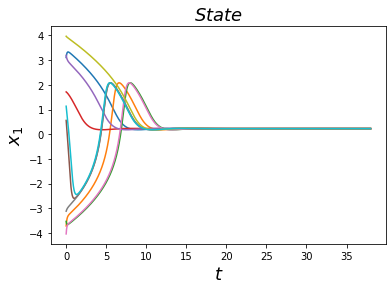

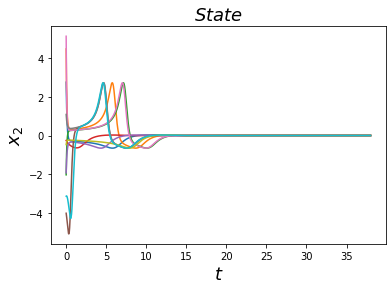

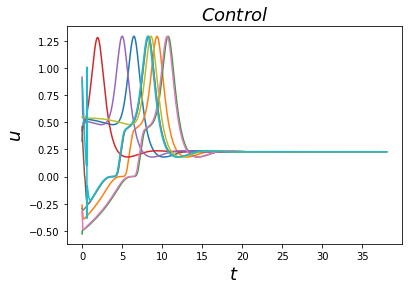

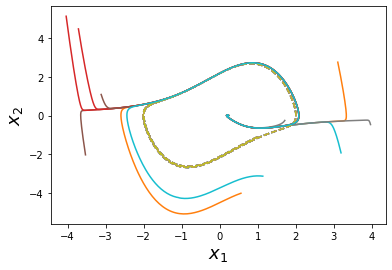

In [13]:
from scipy import linspace
from scipy.integrate import solve_ivp

# For reproducibility
torch.manual_seed(3407)

def vdp(t, z):
    x, y = z
    return [y, mu*(1 - x**2)*y - x]
    
# 10 different initial conditions
for k in range(10):  
  x_init=1*torch.Tensor(1, nx).uniform_(-6, 6)
  NT=3800
  times=torch.linspace(0,NT*T,NT)
  xnew=torch.zeros((NT,nx))
  unew=torch.zeros((1,1))
  y1=torch.zeros((1,nz))
  U=torch.zeros((NT,1))
  for i in range(NT):
    xnew[i,:]=x_init

    # Valid Control Lyapunov function (CLF)
    V_clf= (model(modelen(x_init.float()).detach()))


    #Sontag's formula
    a=torch.diagonal(torch.mm(torch.mm(torch.mm(dtanh(V_clf),model.layer2.weight)*dtanh(torch.tanh(torch.mm(modelen(x_init.float()),model.layer1.weight.t())+model.layer1.bias)),model.layer1.weight),torch.matmul(((K-torch.eye(nz))/T),modelen(x_init.float()).t()).float()),0)
    b=torch.diagonal(torch.mm(torch.mm(torch.mm(dtanh(V_clf),model.layer2.weight)*dtanh(torch.tanh(torch.mm(modelen(x_init.float()),model.layer1.weight.t())+model.layer1.bias)),model.layer1.weight),(torch.matmul(B1/T,modelen(x_init.float()).t())).float()),0)
    unew=torch.div(-a-torch.pow((torch.pow(a,2)+torch.pow(b,4)),0.5),b)
    if b==torch.zeros((1,1)):
      unew=torch.zeros((1,1))

    # Append unew to U
    U[i,:]=unew
    unew=1*torch.ones((1,1))*unew

    #Propogate to the next state
    y1=f_next(x_init,unew)
    x_init=y1

  # Ploting
  plt.figure(1)
  plt.plot(times.numpy(),(xnew[:,0]).numpy())
  plt.xlabel('$t$',fontsize=18)
  plt.ylabel('$x_1$',fontsize=18) 
  plt.title('$State$',fontsize=18)

  plt.figure(2)
  plt.plot(times.numpy(),xnew[:,1].numpy())
  plt.xlabel('$t$',fontsize=18)
  plt.ylabel('$x_2$',fontsize=18) 
  plt.title('$State$',fontsize=18)

  plt.figure(3)
  plt.plot(times.numpy(),U[:,0].detach().numpy())
  plt.xlabel('$t$',fontsize=18)
  plt.ylabel('$u$',fontsize=18) 
  plt.title('$Control$',fontsize=18)

  plt.figure(4)
  a, b = 0, 10
  mus = [1]
  styles = [ "--"]
  t = linspace(a, b, 500)
  plt.xlabel('$x_1$',fontsize=18)
  plt.ylabel('$x_2$',fontsize=18)
  for mu, style in zip(mus, styles):
    sol = solve_ivp(vdp, [a, b], [1, -1.1], t_eval=t)
    plt.plot(sol.y[0], sol.y[1], style)
  plt.plot(xnew[:,0].numpy(),xnew[:,1].numpy()) 
plt.show()



### Checking whether V is a CLF for smaller epsilon

---



In [14]:
epsilon = -0.00001
start_ = timeit.default_timer() 
result = CheckLyapunovKoopman(varsx_, f_koop, V_learn, ball_lb, ball_ub, config,epsilon,K,varsz_)
stop_ = timeit.default_timer() 

if (result): 
    print("Not a Control Lyapunov function (CLF). Found counterexample: ")
    print(result)
else:  
    print("Satisfy conditions with epsilon= ",epsilon)
    print(V_learn, " is a Control Lyapunov function (CLF).")
t += (stop_ - start_)

Satisfy conditions with epsilon=  -1e-05
tanh((-0.012092807330191135 - 0.17871952056884766 * tanh((-0.32727363705635071 + 0.71324664354324341 * tanh((-0.27082619071006775 - 0.19219104945659637 * tanh((-0.6203923225402832 - 0.032089672982692719 * x1 - 0.021821761503815651 * x2)) + 0.45852082967758179 * tanh((-0.43020275235176086 - 0.03713521733880043 * x1 - 0.048148579895496368 * x2)) - 0.27789792418479919 * tanh((0.43350261449813843 + 0.5502547025680542 * x1 + 0.16169874370098114 * x2)) + 0.22751183807849884 * tanh((0.43482142686843872 + 0.050561245530843735 * x1 + 0.056328091770410538 * x2)) - 0.17474763095378876 * tanh((0.43580788373947144 + 0.27771469950675964 * x1 + 0.82458895444869995 * x2)) + 0.3690737783908844 * tanh((0.76832675933837891 + 0.21487809717655182 * x1 + 0.073080003261566162 * x2)))) - 0.034484464675188065 * tanh((-0.048447802662849426 + 0.25697901844978333 * tanh((-0.6203923225402832 - 0.032089672982692719 * x1 - 0.021821761503815651 * x2)) + 0.61167752742767334 * t